In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
!pip install torchsummary
from torchsummary import summary

In [3]:
train = datasets.CIFAR10(root='./data', train=True,
                                        download=True, \
                         )
test = datasets.CIFAR10(root='./data', train=False,
                                       download=True, \
                        )

Files already downloaded and verified
Files already downloaded and verified


In [4]:
max_pixel_value = train.data.max()
max_pixel_value
data = train.data/max_pixel_value

In [5]:
data.shape

(50000, 32, 32, 3)

In [6]:
data[:,:,:,0].mean(),data[:,:,:,0].std()

(0.49139967861519745, 0.2470322324632823)

In [7]:
data[:,:,:,1].mean(),data[:,:,:,1].std()

(0.4821584083946076, 0.24348512800005553)

In [8]:
data[:,:,:,2].mean(),data[:,:,:,2].std()

(0.44653091444546616, 0.2615878417279641)

In [9]:
# Train Phase transformations
train_transforms = transforms.Compose([

                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([

                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                       ])


In [10]:
train = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
test = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4,\
                       pin_memory=True) if cuda else\
                      dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


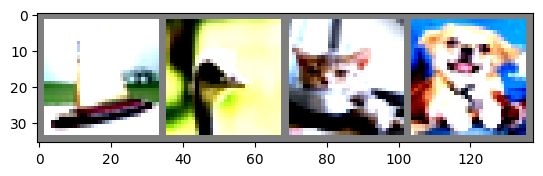

ship  bird  cat   dog  


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

## Import all the models

In [14]:
from model import (BatchNormNet,\
                   LayerNormNet,\
                   GroupNormNet)

In [16]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

## Batch Normalization

In [32]:


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = BatchNormNet().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 32, 32]             648
              ReLU-2           [-1, 24, 32, 32]               0
       BatchNorm2d-3           [-1, 24, 32, 32]              48
           Dropout-4           [-1, 24, 32, 32]               0
            Conv2d-5           [-1, 48, 32, 32]          10,368
              ReLU-6           [-1, 48, 32, 32]               0
       BatchNorm2d-7           [-1, 48, 32, 32]              96
           Dropout-8           [-1, 48, 32, 32]               0
            Conv2d-9           [-1, 12, 32, 32]             576
        MaxPool2d-10           [-1, 12, 16, 16]               0
           Conv2d-11           [-1, 24, 16, 16]           2,592
             ReLU-12           [-1, 24, 16, 16]               0
      BatchNorm2d-13           [-1, 24, 16, 16]              48
           Conv2d-14           [-1

In [33]:
from torch.optim.lr_scheduler import StepLR

model =  BatchNormNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.5347362756729126 Batch_id=97 Accuracy=31.69: 100%|██████████| 98/98 [00:21<00:00,  4.65it/s]



Test set: Average loss: 1.7330, Accuracy: 3496/10000 (34.96%)

EPOCH: 1


Loss=1.3481476306915283 Batch_id=97 Accuracy=47.27: 100%|██████████| 98/98 [00:17<00:00,  5.49it/s]



Test set: Average loss: 1.4062, Accuracy: 4815/10000 (48.15%)

EPOCH: 2


Loss=1.228759527206421 Batch_id=97 Accuracy=56.08: 100%|██████████| 98/98 [00:16<00:00,  5.98it/s]



Test set: Average loss: 1.1991, Accuracy: 5607/10000 (56.07%)

EPOCH: 3


Loss=1.0651073455810547 Batch_id=97 Accuracy=60.95: 100%|██████████| 98/98 [00:15<00:00,  6.17it/s]



Test set: Average loss: 1.1239, Accuracy: 5872/10000 (58.72%)

EPOCH: 4


Loss=1.0624046325683594 Batch_id=97 Accuracy=64.24: 100%|██████████| 98/98 [00:17<00:00,  5.58it/s]



Test set: Average loss: 1.0346, Accuracy: 6264/10000 (62.64%)

EPOCH: 5


Loss=0.9380862712860107 Batch_id=97 Accuracy=66.37: 100%|██████████| 98/98 [00:16<00:00,  5.84it/s]



Test set: Average loss: 1.0495, Accuracy: 6168/10000 (61.68%)

EPOCH: 6


Loss=0.8493394255638123 Batch_id=97 Accuracy=68.72: 100%|██████████| 98/98 [00:16<00:00,  6.08it/s]



Test set: Average loss: 0.9503, Accuracy: 6532/10000 (65.32%)

EPOCH: 7


Loss=0.8634822368621826 Batch_id=97 Accuracy=69.82: 100%|██████████| 98/98 [00:18<00:00,  5.40it/s]



Test set: Average loss: 0.9179, Accuracy: 6725/10000 (67.25%)

EPOCH: 8


Loss=0.8628796935081482 Batch_id=97 Accuracy=71.10: 100%|██████████| 98/98 [00:15<00:00,  6.19it/s]



Test set: Average loss: 0.9118, Accuracy: 6767/10000 (67.67%)

EPOCH: 9


Loss=0.7999456524848938 Batch_id=97 Accuracy=72.41: 100%|██████████| 98/98 [00:16<00:00,  5.92it/s]



Test set: Average loss: 0.8849, Accuracy: 6855/10000 (68.55%)

EPOCH: 10


Loss=0.7828627824783325 Batch_id=97 Accuracy=73.82: 100%|██████████| 98/98 [00:16<00:00,  6.08it/s]



Test set: Average loss: 0.9343, Accuracy: 6718/10000 (67.18%)

EPOCH: 11


Loss=0.7866171598434448 Batch_id=97 Accuracy=74.69: 100%|██████████| 98/98 [00:16<00:00,  6.05it/s]



Test set: Average loss: 0.8343, Accuracy: 7038/10000 (70.38%)

EPOCH: 12


Loss=0.6710302233695984 Batch_id=97 Accuracy=75.60: 100%|██████████| 98/98 [00:16<00:00,  5.82it/s]



Test set: Average loss: 0.8236, Accuracy: 7142/10000 (71.42%)

EPOCH: 13


Loss=0.6912097930908203 Batch_id=97 Accuracy=76.49: 100%|██████████| 98/98 [00:16<00:00,  5.86it/s]



Test set: Average loss: 0.7998, Accuracy: 7160/10000 (71.60%)

EPOCH: 14


Loss=0.5559909343719482 Batch_id=97 Accuracy=77.02: 100%|██████████| 98/98 [00:17<00:00,  5.46it/s]



Test set: Average loss: 0.7609, Accuracy: 7294/10000 (72.94%)

EPOCH: 15


Loss=0.6252735257148743 Batch_id=97 Accuracy=77.76: 100%|██████████| 98/98 [00:23<00:00,  4.15it/s]



Test set: Average loss: 0.7807, Accuracy: 7275/10000 (72.75%)

EPOCH: 16


Loss=0.630427360534668 Batch_id=97 Accuracy=78.25: 100%|██████████| 98/98 [00:17<00:00,  5.50it/s]



Test set: Average loss: 0.7409, Accuracy: 7395/10000 (73.95%)

EPOCH: 17


Loss=0.5808922052383423 Batch_id=97 Accuracy=79.00: 100%|██████████| 98/98 [00:16<00:00,  5.90it/s]



Test set: Average loss: 0.7661, Accuracy: 7331/10000 (73.31%)

EPOCH: 18


Loss=0.5684714913368225 Batch_id=97 Accuracy=79.41: 100%|██████████| 98/98 [00:17<00:00,  5.66it/s]



Test set: Average loss: 0.7669, Accuracy: 7294/10000 (72.94%)

EPOCH: 19


Loss=0.48368221521377563 Batch_id=97 Accuracy=80.09: 100%|██████████| 98/98 [00:16<00:00,  5.80it/s]



Test set: Average loss: 0.7187, Accuracy: 7470/10000 (74.70%)



## Layer Normalization

In [34]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = LayerNormNet().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 32, 32]             648
              ReLU-2           [-1, 24, 32, 32]               0
         LayerNorm-3           [-1, 24, 32, 32]          49,152
           Dropout-4           [-1, 24, 32, 32]               0
            Conv2d-5           [-1, 48, 32, 32]          10,368
              ReLU-6           [-1, 48, 32, 32]               0
         LayerNorm-7           [-1, 48, 32, 32]          98,304
           Dropout-8           [-1, 48, 32, 32]               0
            Conv2d-9           [-1, 12, 32, 32]             576
        MaxPool2d-10           [-1, 12, 16, 16]               0
           Conv2d-11           [-1, 24, 16, 16]           2,592
             ReLU-12           [-1, 24, 16, 16]               0
        LayerNorm-13           [-1, 24, 16, 16]          12,288
           Conv2d-14           [-1

In [35]:
model =  LayerNormNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.7470331192016602 Batch_id=97 Accuracy=27.39: 100%|██████████| 98/98 [00:18<00:00,  5.43it/s]



Test set: Average loss: 1.7027, Accuracy: 3806/10000 (38.06%)

EPOCH: 1


Loss=1.3835378885269165 Batch_id=97 Accuracy=43.53: 100%|██████████| 98/98 [00:16<00:00,  5.89it/s]



Test set: Average loss: 1.3942, Accuracy: 4945/10000 (49.45%)

EPOCH: 2


Loss=1.2381868362426758 Batch_id=97 Accuracy=51.50: 100%|██████████| 98/98 [00:18<00:00,  5.35it/s]



Test set: Average loss: 1.2511, Accuracy: 5444/10000 (54.44%)

EPOCH: 3


Loss=1.2640169858932495 Batch_id=97 Accuracy=56.76: 100%|██████████| 98/98 [00:16<00:00,  5.84it/s]



Test set: Average loss: 1.1449, Accuracy: 5849/10000 (58.49%)

EPOCH: 4


Loss=1.014312744140625 Batch_id=97 Accuracy=60.81: 100%|██████████| 98/98 [00:19<00:00,  5.13it/s]



Test set: Average loss: 1.1064, Accuracy: 5996/10000 (59.96%)

EPOCH: 5


Loss=1.1334435939788818 Batch_id=97 Accuracy=63.34: 100%|██████████| 98/98 [00:16<00:00,  5.82it/s]



Test set: Average loss: 1.0135, Accuracy: 6394/10000 (63.94%)

EPOCH: 6


Loss=0.8544698357582092 Batch_id=97 Accuracy=65.85: 100%|██████████| 98/98 [00:17<00:00,  5.52it/s]



Test set: Average loss: 0.9479, Accuracy: 6615/10000 (66.15%)

EPOCH: 7


Loss=0.831525981426239 Batch_id=97 Accuracy=67.83: 100%|██████████| 98/98 [00:16<00:00,  5.87it/s]



Test set: Average loss: 0.9417, Accuracy: 6631/10000 (66.31%)

EPOCH: 8


Loss=0.8260941505432129 Batch_id=97 Accuracy=69.36: 100%|██████████| 98/98 [00:18<00:00,  5.34it/s]



Test set: Average loss: 0.9249, Accuracy: 6681/10000 (66.81%)

EPOCH: 9


Loss=0.8433015942573547 Batch_id=97 Accuracy=70.57: 100%|██████████| 98/98 [00:16<00:00,  5.81it/s]



Test set: Average loss: 0.8836, Accuracy: 6868/10000 (68.68%)

EPOCH: 10


Loss=0.8014921545982361 Batch_id=97 Accuracy=71.98: 100%|██████████| 98/98 [00:17<00:00,  5.60it/s]



Test set: Average loss: 0.8404, Accuracy: 7013/10000 (70.13%)

EPOCH: 11


Loss=0.6956847906112671 Batch_id=97 Accuracy=72.62: 100%|██████████| 98/98 [00:16<00:00,  5.82it/s]



Test set: Average loss: 0.8364, Accuracy: 7077/10000 (70.77%)

EPOCH: 12


Loss=0.7349532842636108 Batch_id=97 Accuracy=74.12: 100%|██████████| 98/98 [00:16<00:00,  5.80it/s]



Test set: Average loss: 0.7622, Accuracy: 7296/10000 (72.96%)

EPOCH: 13


Loss=0.6864433288574219 Batch_id=97 Accuracy=75.02: 100%|██████████| 98/98 [00:16<00:00,  5.96it/s]



Test set: Average loss: 0.7683, Accuracy: 7332/10000 (73.32%)

EPOCH: 14


Loss=0.6201745271682739 Batch_id=97 Accuracy=75.77: 100%|██████████| 98/98 [00:17<00:00,  5.76it/s]



Test set: Average loss: 0.7682, Accuracy: 7318/10000 (73.18%)

EPOCH: 15


Loss=0.6409803032875061 Batch_id=97 Accuracy=76.80: 100%|██████████| 98/98 [00:16<00:00,  5.77it/s]



Test set: Average loss: 0.7453, Accuracy: 7385/10000 (73.85%)

EPOCH: 16


Loss=0.755397379398346 Batch_id=97 Accuracy=77.21: 100%|██████████| 98/98 [00:16<00:00,  6.01it/s]



Test set: Average loss: 0.7467, Accuracy: 7402/10000 (74.02%)

EPOCH: 17


Loss=0.63359135389328 Batch_id=97 Accuracy=77.86: 100%|██████████| 98/98 [00:16<00:00,  5.83it/s]



Test set: Average loss: 0.7361, Accuracy: 7398/10000 (73.98%)

EPOCH: 18


Loss=0.5289456844329834 Batch_id=97 Accuracy=78.34: 100%|██████████| 98/98 [00:16<00:00,  6.03it/s]



Test set: Average loss: 0.7359, Accuracy: 7449/10000 (74.49%)

EPOCH: 19


Loss=0.6380348801612854 Batch_id=97 Accuracy=78.98: 100%|██████████| 98/98 [00:16<00:00,  5.84it/s]



Test set: Average loss: 0.7268, Accuracy: 7467/10000 (74.67%)



## Group Normalization

In [17]:

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = GroupNormNet().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 32, 32]             648
              ReLU-2           [-1, 24, 32, 32]               0
         GroupNorm-3           [-1, 24, 32, 32]              48
           Dropout-4           [-1, 24, 32, 32]               0
            Conv2d-5           [-1, 48, 32, 32]          10,368
              ReLU-6           [-1, 48, 32, 32]               0
         GroupNorm-7           [-1, 48, 32, 32]              96
           Dropout-8           [-1, 48, 32, 32]               0
            Conv2d-9           [-1, 12, 32, 32]             576
        MaxPool2d-10           [-1, 12, 16, 16]               0
           Conv2d-11           [-1, 24, 16, 16]           2,592
             ReLU-12           [-1, 24, 16, 16]               0
        GroupNorm-13           [-1, 24, 16, 16]              48
           Conv2d-14           [-1

In [18]:
model =  GroupNormNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.6756054162979126 Batch_id=97 Accuracy=27.40: 100%|██████████| 98/98 [00:14<00:00,  6.76it/s]



Test set: Average loss: 1.7537, Accuracy: 3393/10000 (33.93%)

EPOCH: 1


Loss=1.4416821002960205 Batch_id=97 Accuracy=41.95: 100%|██████████| 98/98 [00:18<00:00,  5.37it/s]



Test set: Average loss: 1.5021, Accuracy: 4531/10000 (45.31%)

EPOCH: 2


Loss=1.2896897792816162 Batch_id=97 Accuracy=50.63: 100%|██████████| 98/98 [00:14<00:00,  6.59it/s]



Test set: Average loss: 1.2782, Accuracy: 5354/10000 (53.54%)

EPOCH: 3


Loss=1.2577588558197021 Batch_id=97 Accuracy=55.95: 100%|██████████| 98/98 [00:15<00:00,  6.41it/s]



Test set: Average loss: 1.2322, Accuracy: 5501/10000 (55.01%)

EPOCH: 4


Loss=1.067655324935913 Batch_id=97 Accuracy=59.54: 100%|██████████| 98/98 [00:14<00:00,  6.57it/s]



Test set: Average loss: 1.1307, Accuracy: 5897/10000 (58.97%)

EPOCH: 5


Loss=1.0647469758987427 Batch_id=97 Accuracy=62.82: 100%|██████████| 98/98 [00:14<00:00,  6.60it/s]



Test set: Average loss: 1.0658, Accuracy: 6221/10000 (62.21%)

EPOCH: 6


Loss=0.9569751024246216 Batch_id=97 Accuracy=65.57: 100%|██████████| 98/98 [00:15<00:00,  6.41it/s]



Test set: Average loss: 0.9702, Accuracy: 6579/10000 (65.79%)

EPOCH: 7


Loss=0.8656907081604004 Batch_id=97 Accuracy=67.68: 100%|██████████| 98/98 [00:16<00:00,  6.00it/s]



Test set: Average loss: 0.9642, Accuracy: 6514/10000 (65.14%)

EPOCH: 8


Loss=0.9111806750297546 Batch_id=97 Accuracy=69.42: 100%|██████████| 98/98 [00:14<00:00,  6.58it/s]



Test set: Average loss: 0.9740, Accuracy: 6441/10000 (64.41%)

EPOCH: 9


Loss=0.7664791345596313 Batch_id=97 Accuracy=71.02: 100%|██████████| 98/98 [00:15<00:00,  6.52it/s]



Test set: Average loss: 0.8492, Accuracy: 7000/10000 (70.00%)

EPOCH: 10


Loss=0.8714901804924011 Batch_id=97 Accuracy=72.16: 100%|██████████| 98/98 [00:15<00:00,  6.31it/s]



Test set: Average loss: 0.8733, Accuracy: 6974/10000 (69.74%)

EPOCH: 11


Loss=0.8190380930900574 Batch_id=97 Accuracy=73.43: 100%|██████████| 98/98 [00:14<00:00,  6.55it/s]



Test set: Average loss: 0.8238, Accuracy: 7062/10000 (70.62%)

EPOCH: 12


Loss=0.7588517069816589 Batch_id=97 Accuracy=73.95: 100%|██████████| 98/98 [00:14<00:00,  6.59it/s]



Test set: Average loss: 0.7925, Accuracy: 7194/10000 (71.94%)

EPOCH: 13


Loss=0.7282997965812683 Batch_id=97 Accuracy=75.16: 100%|██████████| 98/98 [00:15<00:00,  6.39it/s]



Test set: Average loss: 0.7897, Accuracy: 7216/10000 (72.16%)

EPOCH: 14


Loss=0.6515085101127625 Batch_id=97 Accuracy=75.97: 100%|██████████| 98/98 [00:15<00:00,  6.46it/s]



Test set: Average loss: 0.7524, Accuracy: 7369/10000 (73.69%)

EPOCH: 15


Loss=0.6950403451919556 Batch_id=97 Accuracy=76.93: 100%|██████████| 98/98 [00:15<00:00,  6.52it/s]



Test set: Average loss: 0.7841, Accuracy: 7251/10000 (72.51%)

EPOCH: 16


Loss=0.6780055165290833 Batch_id=97 Accuracy=77.24: 100%|██████████| 98/98 [00:14<00:00,  6.59it/s]



Test set: Average loss: 0.7334, Accuracy: 7432/10000 (74.32%)

EPOCH: 17


Loss=0.5412017107009888 Batch_id=97 Accuracy=77.99: 100%|██████████| 98/98 [00:14<00:00,  6.55it/s]



Test set: Average loss: 0.7082, Accuracy: 7526/10000 (75.26%)

EPOCH: 18


Loss=0.6315529346466064 Batch_id=97 Accuracy=78.85: 100%|██████████| 98/98 [00:16<00:00,  5.98it/s]



Test set: Average loss: 0.7270, Accuracy: 7462/10000 (74.62%)

EPOCH: 19


Loss=0.5359470248222351 Batch_id=97 Accuracy=79.28: 100%|██████████| 98/98 [00:15<00:00,  6.53it/s]



Test set: Average loss: 0.7109, Accuracy: 7518/10000 (75.18%)

